## - Obtain astronomical tide from TG data. 
## - Harmonic analysis using Utide
## - Simulate future AT 

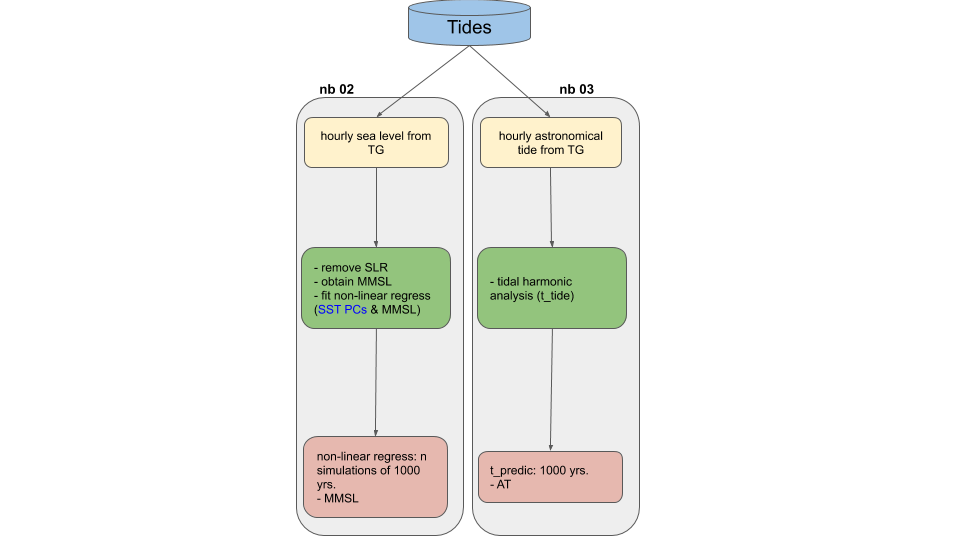

In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# basic import
import os
import os.path as op

# python libs
import numpy as np
import xarray as xr
from datetime import datetime, timedelta

# custom libs
import utide # https://github.com/wesleybowman/UTide
import matplotlib

# DEV: override installed teslakit
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..'))

# teslakit
from teslakit.database import Database
from teslakit.plotting.tides import Plot_AstronomicalTide, Plot_ValidateTTIDE, Plot_Validate_scatter
from teslakit.util.time_operations import DateConverter_Mat2Py



## Database and Site parameters

In [2]:
# --------------------------------------
# Teslakit database

p_data = r'/Users/albacid/Projects/TeslaKit_projects'
db = Database(p_data)

# set site
db.SetSite('GUAM')


In [3]:
# --------------------------------------
# Load astronomical tide historical and set simulation dates
TIDE_astro =  db.Load_TG()      

# TG latitude
lat0 = 13.5

# Simulation dates
d1_sim = np.datetime64('1700-01-01')
d2_sim = np.datetime64('2700-01-01')


In [4]:
# dates to python datetime
TIDE_astro['time'].values = DateConverter_Mat2Py(TIDE_astro['time'].values)
TIDE_astro['time'].values = TIDE_astro['time'].values.astype('datetime64[h]')



## Astronomical Tide

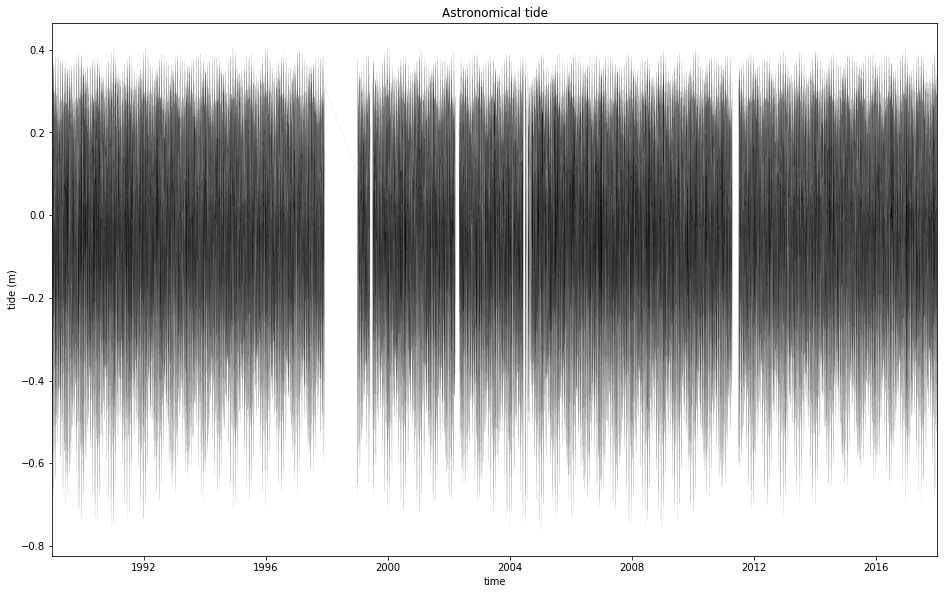

In [5]:
# --------------------------------------
# astronomical tide data

# remove tide nanmean
TIDE_astro['TIDE'] = TIDE_astro.TIDE - np.nanmean(TIDE_astro.TIDE)

# Plot astronomical tide
time = TIDE_astro.time.values[:]
tide = TIDE_astro.TIDE.values[:]

Plot_AstronomicalTide(time, tide);



## Astronomical Tide - Fitting

solve: matrix prep ... solution ... diagnostics ... done.
dict_keys(['name', 'aux', 'nR', 'nNR', 'nI', 'weights', 'A', 'g', 'mean', 'slope', 'g_ci', 'A_ci', 'diagn'])

prep/calcs ... done.
dict_keys(['t_in', 'epoch', 'constit', 'min_SNR', 'min_PE', 't_mpl', 'h'])


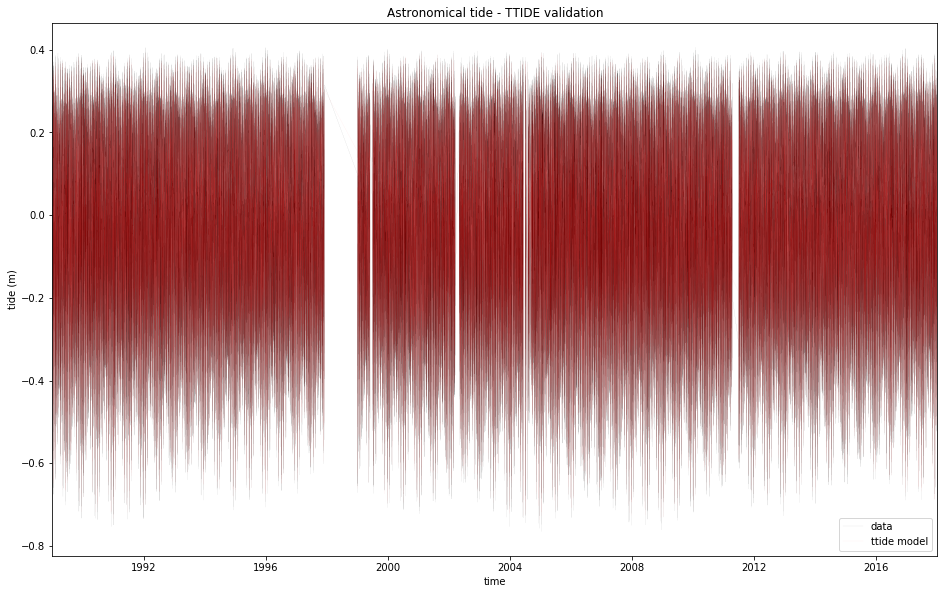

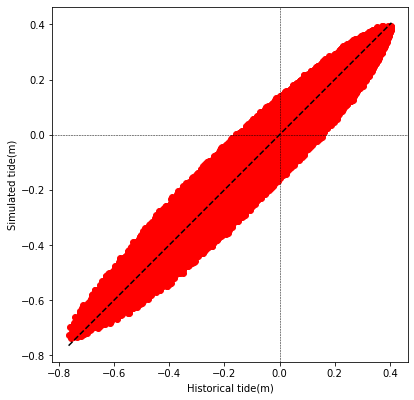

In [6]:
# --------------------------------------
# Utide library - Validation
coef = utide.solve(matplotlib.dates.date2num(time), tide,
                   lat=lat0,
                   nodal=True,
                   method='ols',
                   conf_int='MC')
print(coef.keys())
print()

tide_tt = utide.reconstruct(matplotlib.dates.date2num(time), coef)
print(tide_tt.keys())
tide_tt = tide_tt.h

# Plot validation 
Plot_ValidateTTIDE(time, tide, tide_tt);
Plot_Validate_scatter(tide, tide_tt, 'Historical tide(m)', 'Simulated tide(m)');



## Astronomical Tide - Prediction

In [7]:
# TODO: too slow (0.5 h). try using smaller time blocks

# --------------------------------------
# Utide library - Prediction
date_pred = np.arange(d1_sim, d2_sim + np.timedelta64(1,'h'), dtype='datetime64[h]')

atide_pred = utide.reconstruct(matplotlib.dates.date2num(date_pred), coef)
atide_pred = atide_pred.h

# Store data
TIDE_astro_sim = xr.Dataset(
    {
        'tide'   :(('time',), atide_pred),
    },
    {'time' : date_pred.astype(datetime)}
)

print(TIDE_astro_sim)

db.Save_TIDE_sim_astro(TIDE_astro_sim)


prep/calcs ... done.
<xarray.Dataset>
Dimensions:  (time: 8765809)
Coordinates:
  * time     (time) object 1700-01-01 1700-01-01T01:00:00 ... 2700-01-01
Data variables:
    tide     (time) float64 -0.05096 0.009973 0.09922 ... 0.09181 0.2634 0.3574


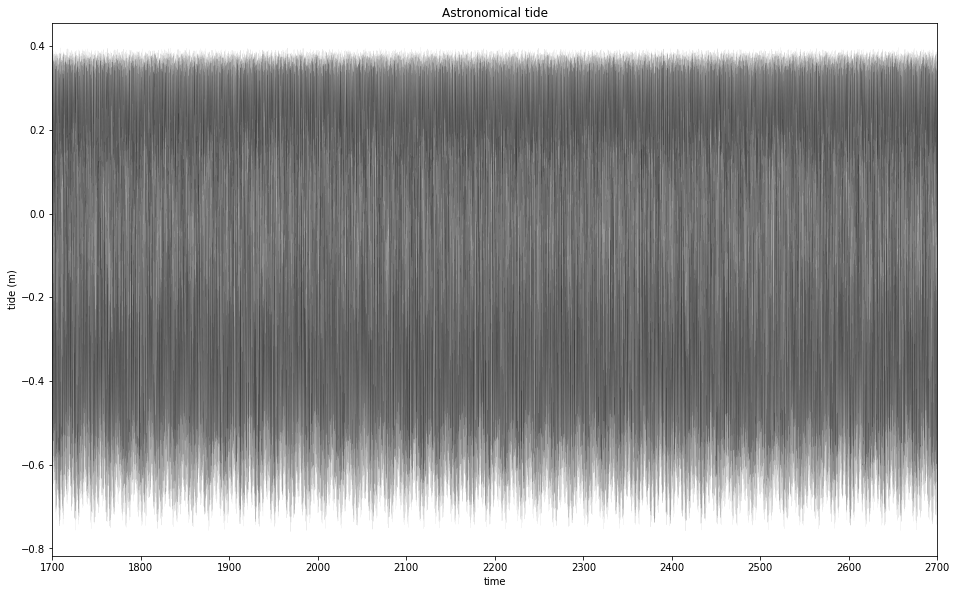

In [8]:
# Plot astronomical tide prediction
time = TIDE_astro_sim.time.values[:]
tide = TIDE_astro_sim.tide.values[:]

Plot_AstronomicalTide(time, tide);
